<h1>Time Series Temperature Prediction</h1>

In this project I will be predicting the daily max temperatures in four different Australian cities (Melbourne, Cairns, Perth, and Alice Springs). I picked these four cities because they are located far away from each other geographically, and have different weather patterns and climates.

The data source I am using is a csv of the weather data from a bunch of different Australian cities. This dataset is publicly available on Kaggle (https://www.kaggle.com/jsphyg/weather-dataset-rattle-package).

In [94]:
import copy
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

These dates are the dates I will be using to split my data for each city into train, validation, and test sets. I experimented with different dates, and ended up picking these dates so that I could get approx. 1 year of data in each of the test and validation sets. So, I have the ~2 most recent years of data as my validation and test data, and the earlier data as my train dataset. 

In [116]:

TRAIN_TEST_SPLIT_DATE = '2015-04-26'
TRAIN_VALIDATION_SPLIT_DATE = '2013-10-01'

<h2>Load Data</h2>

In [226]:
weather_data = pd.read_csv('weatherAUS.csv')

In [227]:
weather_data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


<h2>Getting Data for Each City</h2>

In [230]:
weather_data = weather_data[['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Sunshine', 'WindGustSpeed']]
melbourne = weather_data[weather_data['Location'] == 'Melbourne'].dropna()
cairns = weather_data[weather_data['Location'] == 'Cairns'].dropna()
perth = weather_data[weather_data['Location'] == 'Perth'].dropna()
alice_springs = weather_data[weather_data['Location'] == 'AliceSprings'].dropna()

In [231]:
melbourne['Date'] = pd.to_datetime(melbourne['Date'])
cairns['Date'] = pd.to_datetime(cairns['Date'])
perth['Date'] = pd.to_datetime(perth['Date'])
alice_springs['Date'] = pd.to_datetime(alice_springs['Date'])

<h1>EDA</h1>

For my exploratory data analysis, I am plotting each of my five features' values over time. I am plotting these features in each of the four cities. After looking at these plots, they confirm that the four cities I chose do have different weather patterns.

Melbourne


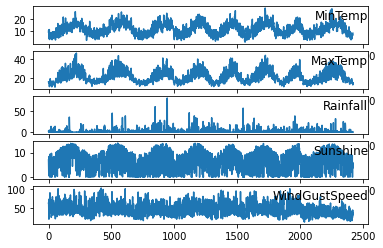

Cairns


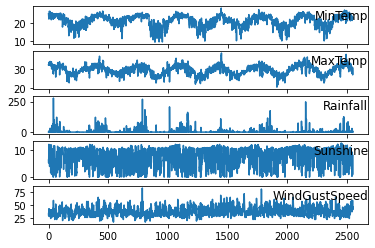

Perth


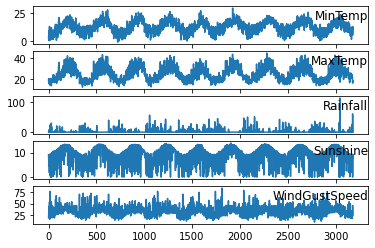

AliceSprings


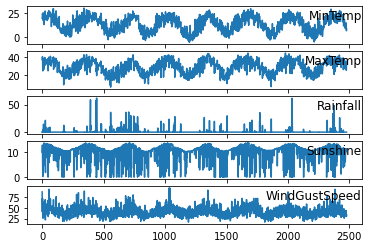

In [233]:
# time series plot of each feature over time
for city in [melbourne, cairns, perth, alice_springs]:
    print(city['Location'].iloc[0])
    values = city.values

    groups = [2, 3, 4, 5, 6]
    i = 1

    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(city.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

<h2>Scaling the Data and Converting Time Series Data to Supervised Data</h2>

In [234]:
# This function is taken from https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [235]:
melbourne = melbourne.set_index('Date').drop(columns=['Location'])
cairns = cairns.set_index('Date').drop(columns=['Location'])
perth = perth.set_index('Date').drop(columns=['Location'])
alice_springs = alice_springs.set_index('Date').drop(columns=['Location'])

In [241]:
# transform daily weather data into supervised data, with 1 week's data used to make predictions
def make_supervised(data_scaled, data):
    data_sup = series_to_supervised(data_scaled, n_in=7, n_out=7)
    drop_cols = ['var1(t)', 'var3(t)', 'var4(t)', 'var5(t)']
    # add future day cols to drop_cols
    for t in range(1, 7):
        for feat in range(1, 6):
            # don't drop predicted max temp 1 week from current day, else drop
            if not (feat == 2):
                drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)
    #data_sup = data_sup.set_index(data.index[7:])
    data_sup = data_sup.set_index(data.index[13:])
    return data_sup

In [272]:
melbourne_vals, cairns_vals, perth_vals, alice_springs_vals = melbourne.values, cairns.values, perth.values, alice_springs.values
melbourne_scaler, cairns_scaler, perth_scaler, alice_springs_scaler = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
melbourne_scaled, cairns_scaled, perth_scaled, alice_springs_scaled = melbourne_scaler.fit_transform(melbourne_vals), cairns_scaler.fit_transform(cairns_vals), perth_scaler.fit_transform(perth_vals), alice_springs_scaler.fit_transform(alice_springs_vals)

melbourne_sup = make_supervised(melbourne_scaled, melbourne)
cairns_sup = make_supervised(cairns_scaled, cairns)
perth_sup = make_supervised(perth_scaled, perth)
alice_springs_sup = make_supervised(alice_springs_scaled, alice_springs)

<h2>Split data into train, validation, and test data</h2>

In [ ]:
melbourne_train, melbourne_validation, melbourne_test = melbourne_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], melbourne_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], melbourne_sup.loc[TRAIN_TEST_SPLIT_DATE:]
cairns_train, cairns_validation, cairns_test = cairns_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], cairns_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], cairns_sup.loc[TRAIN_TEST_SPLIT_DATE:]
perth_train, perth_validation, perth_test = perth_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], perth_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], perth_sup.loc[TRAIN_TEST_SPLIT_DATE:]
alice_springs_train, alice_springs_validation, alice_springs_test = alice_springs_sup.loc[:TRAIN_VALIDATION_SPLIT_DATE], alice_springs_sup.loc[TRAIN_VALIDATION_SPLIT_DATE:TRAIN_TEST_SPLIT_DATE], alice_springs_sup.loc[TRAIN_TEST_SPLIT_DATE:]

In [273]:
alice_springs_train

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),...,var3(t-1),var4(t-1),var5(t-1),var2(t),var2(t+1),var2(t+2),var2(t+3),var2(t+4),var2(t+5),var2(t+6)
Date,,,,,,,,,,,,,,,,,,,,,
2008-12-14,0.698592,0.807388,0.000000,0.731343,0.886076,0.738028,0.846966,0.019355,0.910448,0.303797,...,0.077419,0.156716,0.177215,0.728232,0.844327,0.833773,0.667546,0.664908,0.517150,0.522427
2008-12-15,0.738028,0.846966,0.019355,0.910448,0.303797,0.791549,0.894459,0.000000,0.940299,0.392405,...,0.009677,0.910448,0.113924,0.844327,0.833773,0.667546,0.664908,0.517150,0.522427,0.567282
2008-12-16,0.791549,0.894459,0.000000,0.940299,0.392405,0.842254,0.883905,0.000000,0.582090,0.696203,...,0.000000,0.820896,0.417722,0.833773,0.667546,0.664908,0.517150,0.522427,0.567282,0.651715
2008-12-17,0.842254,0.883905,0.000000,0.582090,0.696203,0.805634,0.670185,0.003226,0.305970,0.367089,...,0.000000,0.649254,0.468354,0.667546,0.664908,0.517150,0.522427,0.567282,0.651715,0.773087
2008-12-18,0.805634,0.670185,0.003226,0.305970,0.367089,0.757746,0.477573,0.041935,0.014925,0.227848,...,0.000000,0.313433,0.582278,0.664908,0.517150,0.522427,0.567282,0.651715,0.773087,0.788918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-25,0.721127,0.757256,0.000000,0.708955,0.443038,0.529577,0.662269,0.000000,0.843284,0.164557,...,0.000000,0.835821,0.227848,0.593668,0.656992,0.736148,0.767810,0.799472,0.804749,0.820580
2013-09-26,0.529577,0.662269,0.000000,0.843284,0.164557,0.470423,0.759894,0.000000,0.805970,0.367089,...,0.000000,0.850746,0.253165,0.656992,0.736148,0.767810,0.799472,0.804749,0.820580,0.575198
2013-09-27,0.470423,0.759894,0.000000,0.805970,0.367089,0.771831,0.741425,0.000000,0.813433,0.670886,...,0.000000,0.858209,0.253165,0.736148,0.767810,0.799472,0.804749,0.820580,0.575198,0.683377


<h2>Split data into x and y datasets</h2>

In these two cells, I am splitting my data into the x data (the weather features from the past week) and the y data (the max temperature). However, I will be testing how accurate my model is when making predictions up to 7 days in the future, so each of my y datasets is actually a list of y datasets (with each item in the list being the y values for if you are predicting n days into the future).

In [274]:
# return x_data, [y_data_1_day_ahead, y_data_2_days_ahead, ... y_data_7_days_ahead]
def x_y_split(data):
    y_data = []
    y_cols = ['var2(t)', 'var2(t+1)', 'var2(t+2)', 'var2(t+3)', 'var2(t+4)', 'var2(t+5)', 'var2(t+6)']
    x_data = data.drop(columns=y_cols)
    for col in y_cols:
        y_data.append(data[[col]].values)
    return x_data, y_data

In [275]:
x_train_melbourne, y_train_melbourne = x_y_split(melbourne_train)
x_validation_melbourne, y_validation_melbourne = x_y_split(melbourne_validation)
x_test_melbourne, y_test_melbourne = x_y_split(melbourne_test)

x_train_cairns, y_train_cairns = x_y_split(cairns_train)
x_validation_cairns, y_validation_cairns = x_y_split(cairns_validation)
x_test_cairns, y_test_cairns = x_y_split(cairns_test)

x_train_perth, y_train_perth = x_y_split(perth_train)
x_validation_perth, y_validation_perth = x_y_split(perth_validation)
x_test_perth, y_test_perth = x_y_split(perth_test)

x_train_alice_springs, y_train_alice_springs = x_y_split(alice_springs_train)
x_validation_alice_springs, y_validation_alice_springs = x_y_split(alice_springs_validation)
x_test_alice_springs, y_test_alice_springs = x_y_split(alice_springs_test)

<h2>Get Baseline Predictions</h2>

I am using a baseline in order to evaluate how well my model will perform. The baseline that I'm using is a model that always predicts the most recent day's max temperature (ex. if we're predicting one day ahead, the baseline will predict the previous day's max temperature). Here, I am getting the predictions that this baseline will make on each of my datasets.

In [276]:
# Baseline 1: Predict the previous day's max temperature
y_train_baseline1_melbourne = [x_train_melbourne['var2(t-1)'].values for i in range(7)]
y_validation_baseline1_melbourne = [x_validation_melbourne['var2(t-1)'].values for i in range(7)]
y_test_baseline1_melbourne = [x_test_melbourne['var2(t-1)'].values for i in range(7)]

y_train_baseline1_cairns = [x_train_cairns['var2(t-1)'].values for i in range(7)]
y_validation_baseline1_cairns = [x_validation_cairns['var2(t-1)'].values for i in range(7)]
y_test_baseline1_cairns = [x_test_cairns['var2(t-1)'].values for i in range(7)]

y_train_baseline1_perth = [x_train_perth['var2(t-1)'].values for i in range(7)]
y_validation_baseline1_perth = [x_validation_perth['var2(t-1)'].values for i in range(7)]
y_test_baseline1_perth = [x_test_perth['var2(t-1)'].values for i in range(7)]

y_train_baseline1_alice_springs = [x_train_alice_springs['var2(t-1)'].values for i in range(7)]
y_validation_baseline1_alice_springs = [x_validation_alice_springs['var2(t-1)'].values for i in range(7)]
y_test_baseline1_alice_springs = [x_test_alice_springs['var2(t-1)'].values for i in range(7)]

<h2>Reshape Data</h2>
We need to reshape the x data so that it can be passed in to the LSTM properly. Instead of passing a list of all of the features on each day to the model, we need to pass a list whose items are 7 x 5 arrays of all of my features. Each of these 7 x 5 arrays has 7 rows of features, with each row including the values of my features n days before the day we're making the prediction on.

In [278]:
# reshape into (num_days, num_timesteps, num_features)
def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.values.shape[0], 7, 5))
    x_validation = x_validation.values.reshape((x_validation.values.shape[0], 7, 5))
    x_test = x_test.values.reshape((x_test.values.shape[0], 7, 5))
    return x_train, x_validation, x_test

In [279]:
x_train_melbourne, x_validation_melbourne, x_test_melbourne = reshape_data(x_train_melbourne, x_validation_melbourne, x_test_melbourne)
x_train_cairns, x_validation_cairns, x_test_cairns = reshape_data(x_train_cairns, x_validation_cairns, x_test_cairns)
x_train_perth, x_validation_perth, x_test_perth = reshape_data(x_train_perth, x_validation_perth, x_test_perth)
x_train_alice_springs, x_validation_alice_springs, x_test_alice_springs = reshape_data(x_train_alice_springs, x_validation_alice_springs, x_test_alice_springs)

<h2>Fit LSTM Models</h2>
Next, we fit an LSTM model for each day ahead (up to 7 days ahead) we are predicting in each of the four cities we are making predictions for.

In [280]:
def fit_lstm(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()
    # 50 neurons in first layer
    model.add(LSTM(50, input_shape=(7, 5)))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=50, batch_size=72, validation_data=(x_validation, y_validation), verbose=0, shuffle=False)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return model

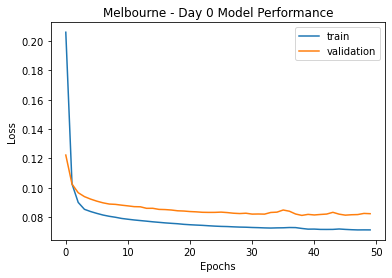

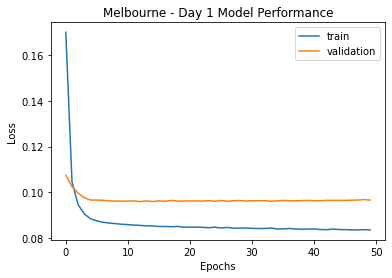

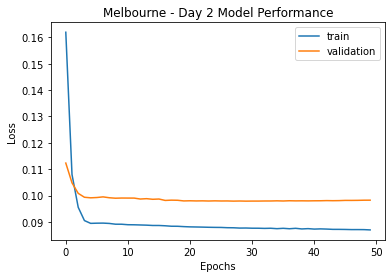

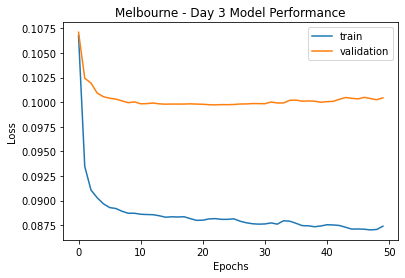

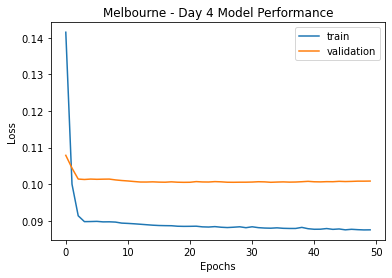

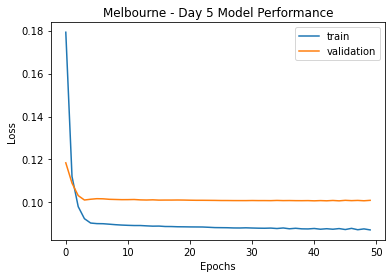

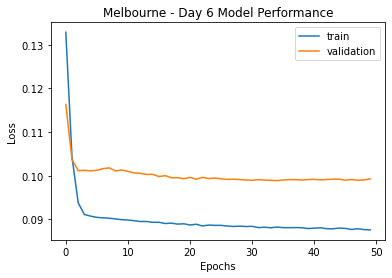

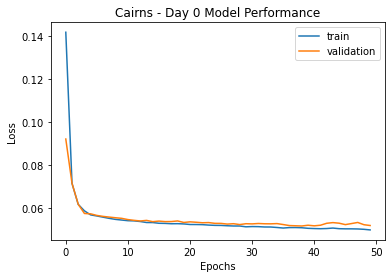

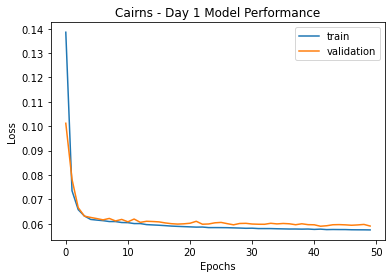

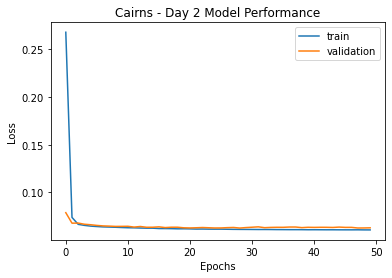

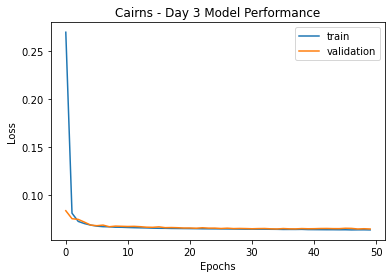

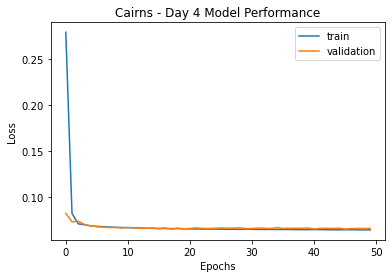

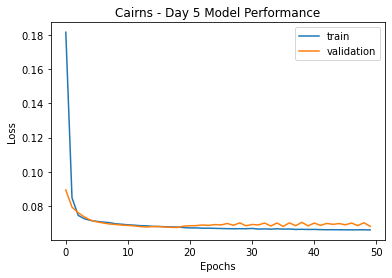

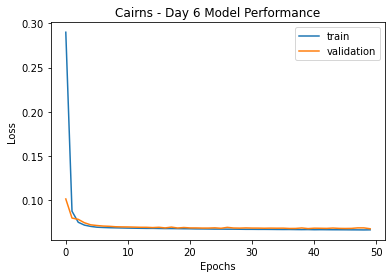

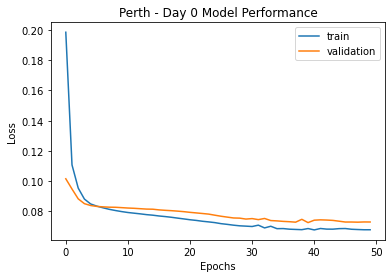

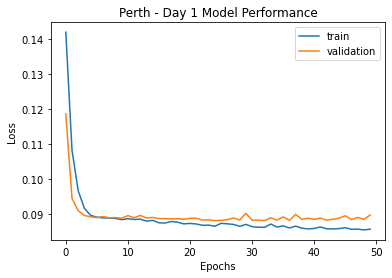

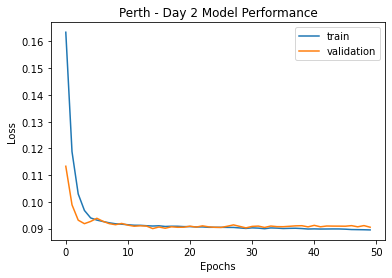

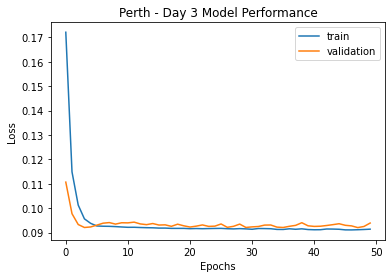

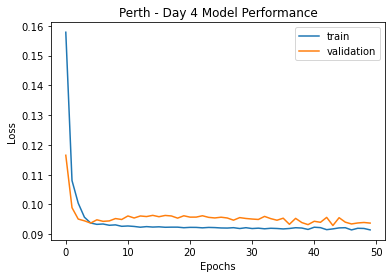

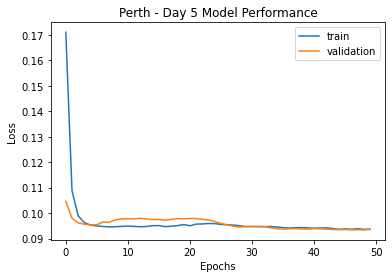

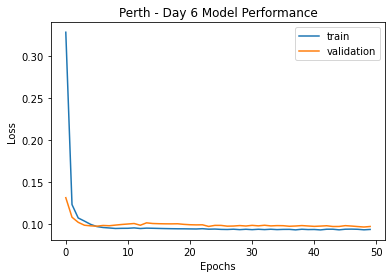

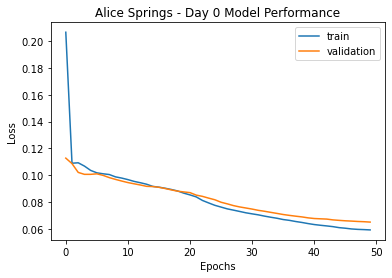

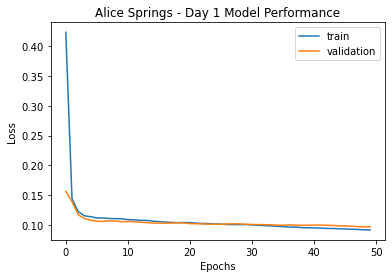

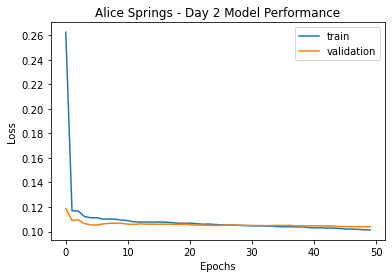

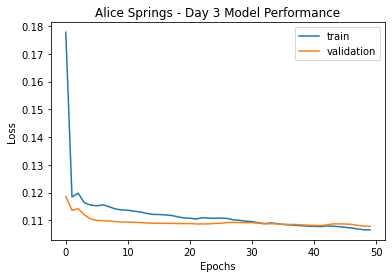

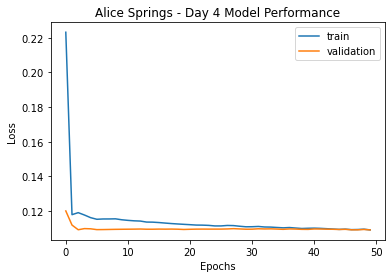

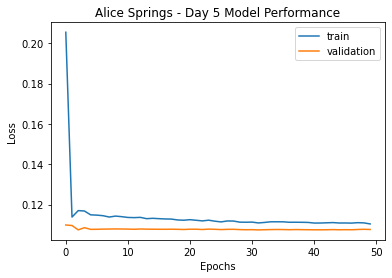

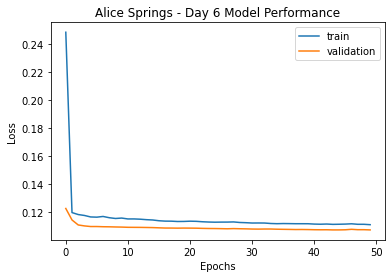

In [281]:
melbourne_models = [fit_lstm(f'Melbourne - Day {i}', x_train_melbourne, y_train_day_i, x_validation_melbourne, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_melbourne, y_validation_melbourne))]
cairns_models = [fit_lstm(f'Cairns - Day {i}', x_train_cairns, y_train_day_i, x_validation_cairns, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_cairns, y_validation_cairns))]
perth_models = [fit_lstm(f'Perth - Day {i}', x_train_perth, y_train_day_i, x_validation_perth, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_perth, y_validation_perth))]
alice_springs_models = [fit_lstm(f'Alice Springs - Day {i}', x_train_alice_springs, y_train_day_i, x_validation_alice_springs, y_validation_day_i)
                    for i, (y_train_day_i, y_validation_day_i) in enumerate(zip(y_train_alice_springs, y_validation_alice_springs))]

<h2>Make Predictions</h2>

In [282]:
y_pred_train_melbourne = [melbourne_model.predict(x_train_melbourne) for melbourne_model in melbourne_models]
y_pred_validation_melbourne = [melbourne_model.predict(x_validation_melbourne) for melbourne_model in melbourne_models]
y_pred_test_melbourne = [melbourne_model.predict(x_test_melbourne) for melbourne_model in melbourne_models]

y_pred_train_cairns = [cairns_model.predict(x_train_cairns) for cairns_model in cairns_models]
y_pred_validation_cairns = [cairns_model.predict(x_validation_cairns) for cairns_model in cairns_models]
y_pred_test_cairns = [cairns_model.predict(x_test_cairns) for cairns_model in cairns_models]

y_pred_train_perth = [perth_model.predict(x_train_perth) for perth_model in perth_models]
y_pred_validation_perth = [perth_model.predict(x_validation_perth) for perth_model in perth_models]
y_pred_test_perth = [perth_model.predict(x_test_perth) for perth_model in perth_models]

y_pred_train_alice_springs = [alice_springs_model.predict(x_train_alice_springs) for alice_springs_model in alice_springs_models]
y_pred_validation_alice_springs = [alice_springs_model.predict(x_validation_alice_springs) for alice_springs_model in alice_springs_models]
y_pred_test_alice_springs = [alice_springs_model.predict(x_test_alice_springs) for alice_springs_model in alice_springs_models]

<h2>Unscale Predictions</h2>

In [285]:
# inverse transform y predictions and test values to get rid of 0-1 scale. To re-use my previous scaler, I need to have df with same #
# of columns, so I use the original values dataframe, substitute my y values in for maxTemp, inverse scale it, and
# extract my unscaled y values
# input: [[list_of_y1_day_1, list_of_y1_day_2, ... list_of_y1_day_7],
#         [list_of_y2_day_1, list_of_y2_day_2, ... list_of_y2_day_7],
#        ...
#        ]
def unscale_y_values(y_vals_list, city_data, city_scaler):
    y_vals_unscaled_tup = ()
    for y_vals in y_vals_list:
        y_unscaled_by_day = []
        #print('unscaling new set of y values')
        for y_vals_day_i in y_vals:
            #print(len(y_vals_day_i))
            #print(y_vals_day_i)
            rescaling_y_vals = copy.copy(city_data)[:len(y_vals_day_i)]
            rescaling_y_vals['MaxTemp'] = y_vals_day_i
            y_vals_unscaled = city_scaler.inverse_transform(rescaling_y_vals.values)[:,1]
            y_unscaled_by_day.append(y_vals_unscaled)
            
        y_vals_unscaled_tup = y_vals_unscaled_tup + (y_unscaled_by_day,)
    return y_vals_unscaled_tup

In [286]:
y_pred_train_melbourne_unscaled, y_train_melbourne_unscaled, y_train_baseline1_melbourne_unscaled,\
y_pred_validation_melbourne_unscaled, y_validation_melbourne_unscaled, y_validation_baseline1_melbourne_unscaled,\
y_pred_test_melbourne_unscaled, y_test_melbourne_unscaled, y_test_baseline1_melbourne_unscaled \
        = unscale_y_values([y_pred_train_melbourne, y_train_melbourne, y_train_baseline1_melbourne,
                            y_pred_validation_melbourne, y_validation_melbourne, y_validation_baseline1_melbourne, 
                            y_pred_test_melbourne, y_test_melbourne, y_test_baseline1_melbourne], melbourne, melbourne_scaler)

y_pred_train_cairns_unscaled, y_train_cairns_unscaled, y_train_baseline1_cairns_unscaled,\
y_pred_validation_cairns_unscaled, y_validation_cairns_unscaled, y_validation_baseline1_cairns_unscaled,\
y_pred_test_cairns_unscaled, y_test_cairns_unscaled, y_test_baseline1_cairns_unscaled \
        = unscale_y_values([y_pred_train_cairns, y_train_cairns, y_train_baseline1_cairns,
                            y_pred_validation_cairns, y_validation_cairns, y_validation_baseline1_cairns,
                            y_pred_test_cairns, y_test_cairns, y_test_baseline1_cairns], cairns, cairns_scaler)

y_pred_train_perth_unscaled, y_train_perth_unscaled, y_train_baseline1_perth_unscaled,\
y_pred_validation_perth_unscaled, y_validation_perth_unscaled, y_validation_baseline1_perth_unscaled,\
y_pred_test_perth_unscaled, y_test_perth_unscaled, y_test_baseline1_perth_unscaled \
        = unscale_y_values([y_pred_train_perth, y_train_perth, y_train_baseline1_perth,
                            y_pred_validation_perth, y_validation_perth, y_validation_baseline1_perth,
                            y_pred_test_perth, y_test_perth, y_test_baseline1_perth], perth, perth_scaler)

y_pred_train_alice_springs_unscaled, y_train_alice_springs_unscaled, y_train_baseline1_alice_springs_unscaled,\
y_pred_validation_alice_springs_unscaled, y_validation_alice_springs_unscaled, y_validation_baseline1_alice_springs_unscaled,\
y_pred_test_alice_springs_unscaled, y_test_alice_springs_unscaled, y_test_baseline1_alice_springs_unscaled \
        = unscale_y_values([y_pred_train_alice_springs, y_train_alice_springs, y_train_baseline1_alice_springs,
                            y_pred_validation_alice_springs, y_validation_alice_springs, y_validation_baseline1_alice_springs,
                            y_pred_test_alice_springs, y_test_alice_springs, y_test_baseline1_alice_springs], alice_springs, alice_springs_scaler)

<h2>Get Results</h2>
We will see how accurate the LSTM models are for each city by comparing their performance to the baseline model. The three accuracy metrics we will use are Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error. We will also see how much the models' performance will increase or decrease as we predict further and further ahead (up to 7 days ahead). These results are printed in both a table format and a graph format. We will do this for our train data, our validation data, and finally, our test data.

In [300]:
def print_accuracy(y_actuals, y_preds, city, dataset_name, model_name):
    # table of accuracy metrics
    mses = [mean_squared_error(y_actual, y_pred) for y_actual, y_pred in zip(y_actuals, y_preds)]
    rmses = [math.sqrt(mean_squared_error(y_actual, y_pred)) for y_actual, y_pred in zip(y_actuals, y_preds)]
    maes = [mean_absolute_error(y_actual, y_pred)  for y_actual, y_pred in zip(y_actuals, y_preds)]
    results_dict = {"How many days ahead we're predicting": list(range(1, 8)), 
                    'Mean Squared Error': mses, 'Root Mean Squared Error': rmses, 'Mean Absolute Error': maes}
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    display(results_df)
    
    # graph format of table
    plt.plot(range(1, 8), mses, label='Mean Squared Error')
    plt.plot(range(1, 8), rmses, label='Root Mean Squared Error')
    plt.plot(range(1, 8), maes, label='Mean Absolute Error')
    plt.title(f"{city.capitalize()} - {dataset_name.capitalize()} Accuracy of {model_name} Over Time")
    plt.xlabel("Accuracy (°C)")
    plt.ylabel("# of days ahead that the model is predicting")
    plt.legend()
    plt.show()

***melbourne results***
train:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,18.287543,29.152383,33.318331,34.117709,33.451201,31.674501,29.913676
Root Mean Squared Error,4.276394,5.399295,5.772203,5.841037,5.783701,5.628010,5.469340
Mean Absolute Error,2.976293,3.898214,4.285653,4.306650,4.330973,4.190579,4.052401


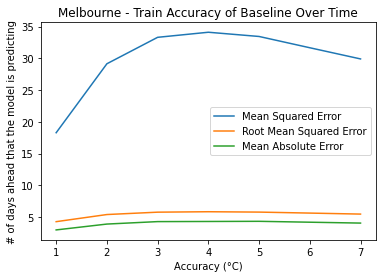



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,12.774213,17.568048,19.023862,18.987439,19.644835,19.827117,20.235846
Root Mean Squared Error,3.574103,4.191426,4.361635,4.357458,4.432249,4.452765,4.498427
Mean Absolute Error,2.609957,3.045409,3.164763,3.162065,3.197707,3.189503,3.216418


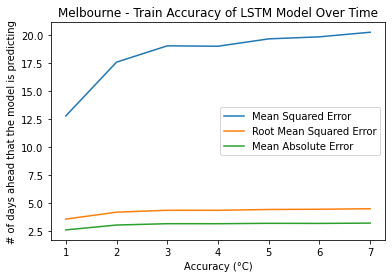



validation:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,23.943223,37.162562,39.444242,40.160496,39.637355,39.006143,39.062948
Root Mean Squared Error,4.893181,6.096110,6.280465,6.337231,6.295820,6.245490,6.250036
Mean Absolute Error,3.566667,4.497796,4.639118,4.751515,4.648485,4.746832,4.687328


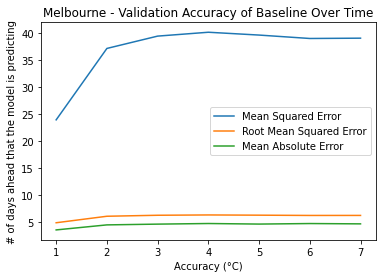



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,16.535831,23.528480,24.497330,24.992265,26.591706,27.057507,27.318974
Root Mean Squared Error,4.066427,4.850616,4.949478,4.999226,5.156715,5.201683,5.226756
Mean Absolute Error,3.003998,3.529035,3.585509,3.666195,3.680206,3.684975,3.623357


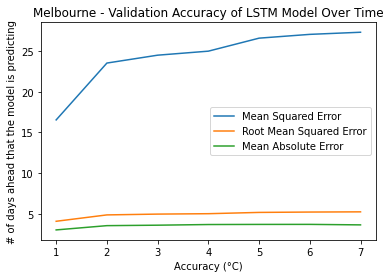







***cairns results***
train:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,1.959547,2.683888,3.288640,3.770744,3.940502,4.088797,4.140175
Root Mean Squared Error,1.399838,1.638257,1.813461,1.941840,1.985070,2.022077,2.034742
Mean Absolute Error,1.009613,1.196675,1.355320,1.430532,1.466324,1.493773,1.521826


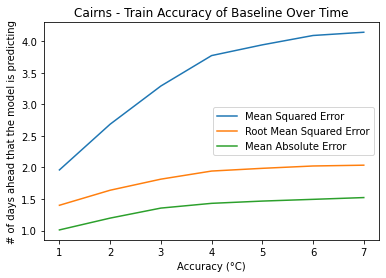



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,1.549409,2.078982,2.304465,2.455774,2.514070,2.600928,2.643958
Root Mean Squared Error,1.244752,1.441868,1.518046,1.567091,1.585582,1.612739,1.626025
Mean Absolute Error,0.908679,1.035128,1.100066,1.141869,1.167245,1.190537,1.204301


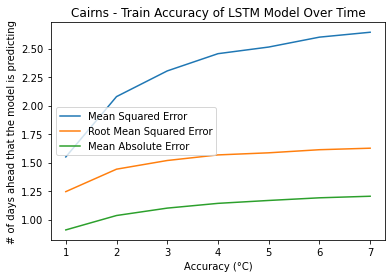



validation:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,2.195062,3.008818,3.698854,3.836420,4.156032,3.968148,3.812046
Root Mean Squared Error,1.481574,1.734595,1.923240,1.958678,2.038635,1.992021,1.952446
Mean Absolute Error,1.071958,1.259259,1.422046,1.427337,1.511287,1.456790,1.454850


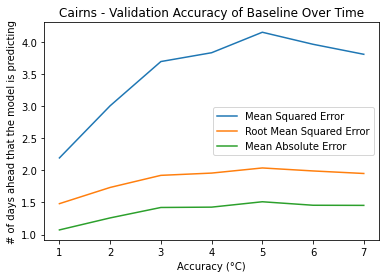



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,1.724247,2.243413,2.497801,2.596577,2.717123,2.834945,2.873791
Root Mean Squared Error,1.313106,1.497803,1.580443,1.611390,1.648370,1.683730,1.695226
Mean Absolute Error,0.950674,1.080757,1.152688,1.175631,1.209982,1.246624,1.246443


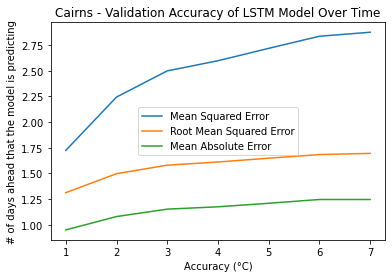







***perth results***
train:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,10.804229,20.038695,25.187584,26.126423,25.595428,24.907955,24.276446
Root Mean Squared Error,3.286979,4.476460,5.018723,5.111401,5.059192,4.990787,4.927113
Mean Absolute Error,2.408126,3.397015,3.829740,3.927253,3.863516,3.815865,3.727087


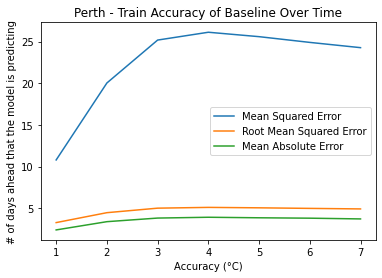



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,8.209049,12.700431,13.821467,14.989766,14.729668,14.627460,15.915896
Root Mean Squared Error,2.865144,3.563766,3.717723,3.871662,3.837925,3.824586,3.989473
Mean Absolute Error,2.132120,2.704427,2.811839,2.901550,2.893042,2.913764,2.982154


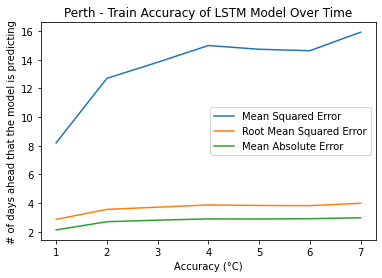



validation:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,12.526189,22.221643,25.457378,24.981591,23.553304,22.696731,22.459738
Root Mean Squared Error,3.539236,4.713984,5.045530,4.998159,4.853175,4.764109,4.739171
Mean Absolute Error,2.577622,3.605944,3.820280,3.783741,3.697378,3.677448,3.730594


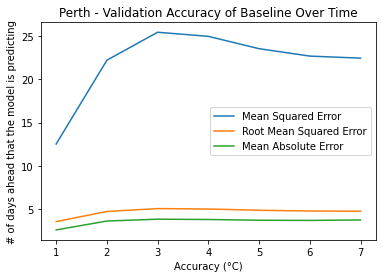



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,9.583017,13.178469,13.509935,15.050466,14.768613,14.379424,16.429126
Root Mean Squared Error,3.095645,3.630216,3.675586,3.879493,3.842995,3.792021,4.053286
Mean Absolute Error,2.307711,2.834332,2.860641,2.967916,2.962457,2.957287,3.062159


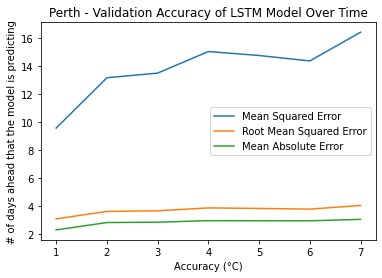







***alice_springs results***
train:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,11.711959,23.809281,31.264504,36.204084,38.219771,40.026832,41.491209
Root Mean Squared Error,3.422274,4.879476,5.591467,6.016983,6.182214,6.326676,6.441367
Mean Absolute Error,2.392494,3.685305,4.354707,4.734351,4.916285,5.038295,5.080662


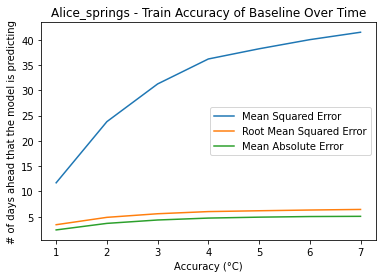



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,9.746257,21.001547,23.722087,24.503144,25.357819,25.547893,26.531161
Root Mean Squared Error,3.121900,4.582744,4.870532,4.950065,5.035655,5.054492,5.150841
Mean Absolute Error,2.222327,3.505445,3.830189,3.942230,4.039923,4.060480,4.106810


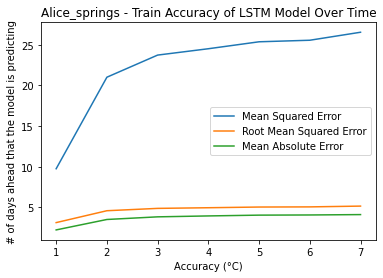



validation:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,13.962681,27.302862,34.912844,40.318804,42.585960,42.340942,42.293659
Root Mean Squared Error,3.736667,5.225214,5.908709,6.349709,6.525792,6.506992,6.503358
Mean Absolute Error,2.656884,3.867754,4.406703,4.879348,5.059964,5.083333,5.111957


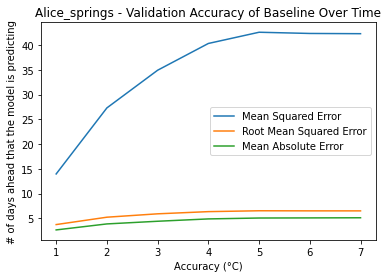



Using my model:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,11.480342,22.746486,25.449847,26.011313,25.694473,24.661055,25.003159
Root Mean Squared Error,3.388265,4.769328,5.044784,5.100129,5.068972,4.965990,5.000316
Mean Absolute Error,2.473697,3.647468,3.940484,4.086157,4.138573,4.078303,4.063648


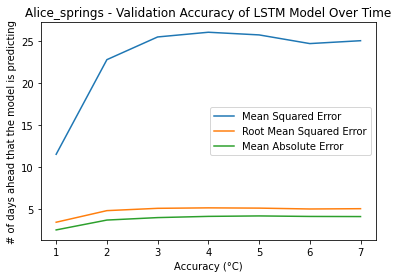

In [301]:
for city in ['melbourne', 'cairns', 'perth', 'alice_springs']:
    print(f'***{city} results***')
    for dataset in ['train', 'validation']:
        actual = eval(f'y_{dataset}_{city}_unscaled')
        pred = eval(f'y_pred_{dataset}_{city}_unscaled')
        baseline1_pred = eval(f'y_{dataset}_baseline1_{city}_unscaled')
        print(f'{dataset}:')
        print('Using baseline 1:')
        print_accuracy(actual, baseline1_pred, city, dataset, 'Baseline')
        print('\n')
        print('Using my model:')
        print_accuracy(actual, pred, city, dataset, 'LSTM Model')
        print('\n')
    print('\n\n\n')

***melbourne results***
test:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,20.567833,34.877595,36.299738,34.330190,32.676024,32.544214,35.461548
Root Mean Squared Error,4.535177,5.905726,6.024926,5.859197,5.716295,5.704754,5.954960
Mean Absolute Error,3.185476,4.329286,4.418333,4.336190,4.165000,4.185000,4.346905


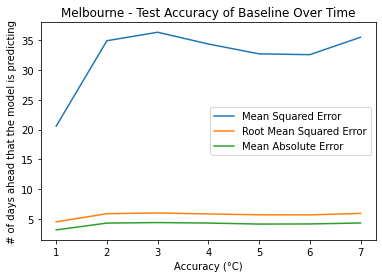

,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,12.950725,19.133535,19.912339,19.366305,19.303691,19.642596,20.589623
Root Mean Squared Error,3.598712,4.374190,4.462324,4.400716,4.393597,4.431997,4.537579
Mean Absolute Error,2.716843,3.330045,3.324663,3.278508,3.218004,3.220684,3.274816


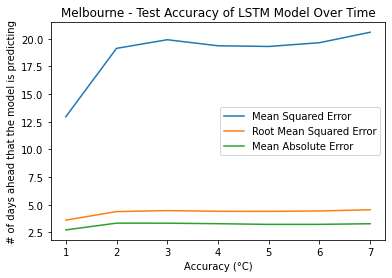







***cairns results***
test:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,1.823937,2.664031,2.987219,3.057062,3.277594,3.481625,3.916906
Root Mean Squared Error,1.350532,1.632186,1.728357,1.748446,1.810413,1.865911,1.979118
Mean Absolute Error,0.994375,1.255313,1.322188,1.344375,1.375313,1.441250,1.497812


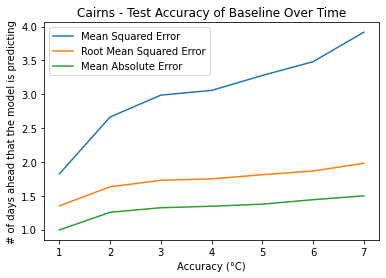

,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,1.447086,1.939587,2.145623,2.249451,2.397540,2.504842,2.527784
Root Mean Squared Error,1.202949,1.392690,1.464795,1.499817,1.548399,1.582669,1.589901
Mean Absolute Error,0.896099,1.017503,1.086677,1.127446,1.183564,1.205653,1.212054


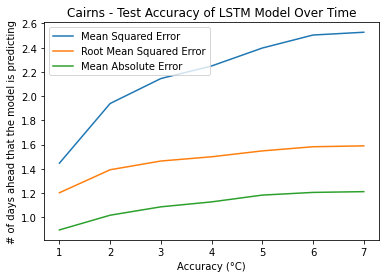







***perth results***
test:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,13.186810,25.957595,30.693734,30.212608,29.540823,29.709025,30.353582
Root Mean Squared Error,3.631365,5.094860,5.540193,5.496600,5.435147,5.450599,5.509409
Mean Absolute Error,2.637215,3.795190,4.095316,4.085823,4.093291,4.112278,4.198861


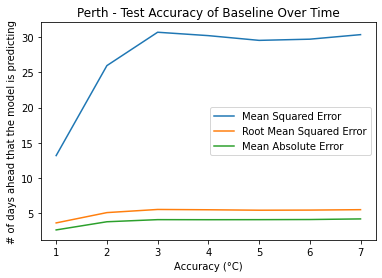

,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,10.164447,16.443740,17.450177,17.993554,17.359956,17.058432,18.202062
Root Mean Squared Error,3.188173,4.055088,4.177341,4.241881,4.166528,4.130185,4.266387
Mean Absolute Error,2.405281,3.088053,3.186688,3.203525,3.176666,3.154824,3.200194


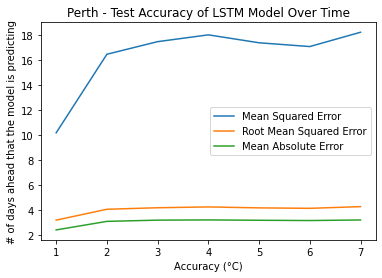







***alice_springs results***
test:
Using baseline 1:


,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,10.716550,21.621754,28.282865,30.152778,29.311959,29.660409,28.067807
Root Mean Squared Error,3.273614,4.649920,5.318164,5.491155,5.414052,5.446137,5.297906
Mean Absolute Error,2.419883,3.736257,4.340351,4.395614,4.285088,4.319883,4.175731


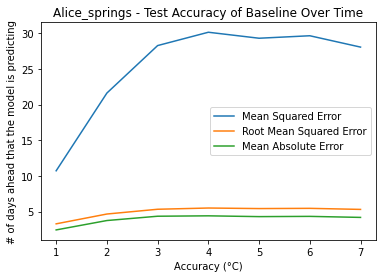

,0,1,2,3,4,5,6
How many days ahead we're predicting,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000
Mean Squared Error,8.682810,16.534057,17.535731,16.935465,16.883780,17.420237,17.300198
Root Mean Squared Error,2.946661,4.066209,4.187569,4.115272,4.108988,4.173756,4.159351
Mean Absolute Error,2.133483,3.217263,3.339519,3.288709,3.312851,3.334414,3.336473


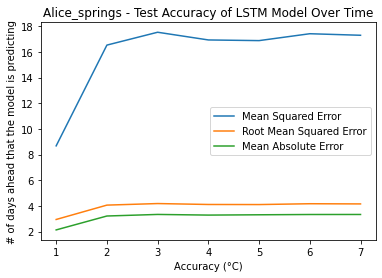

In [302]:
for city in ['melbourne', 'cairns', 'perth', 'alice_springs']:
    print(f'***{city} results***')
    for dataset in ['test']:
        actual = eval(f'y_{dataset}_{city}_unscaled')
        pred = eval(f'y_pred_{dataset}_{city}_unscaled')
        baseline1_pred = eval(f'y_{dataset}_baseline1_{city}_unscaled')
        print(f'{dataset}:')
        print('Using baseline 1:')
        print_accuracy(actual, baseline1_pred, city, dataset, 'Baseline')
        print('\n')
        print_accuracy(actual, pred, city, dataset, 'LSTM Model')
        print('\n')
    print('\n\n\n')